#  Objective 1: Meta-Learning Concepts & Practice

This notebook provides a comprehensive overview and practical demonstration of meta-learning,
covering concepts like few-shot learning, Hebbian updates, and Model-Agnostic Meta-Learning (MAML).


**Meta-Learning and Few-Shot Learning: A One-Page Summary**

Meta-learning, or "learning to learn," is a paradigm in machine learning where models are trained to adapt quickly to new tasks using minimal data. This approach is particularly useful in scenarios where data is scarce, such as personalized medicine, robotics, or mobile applications. Unlike traditional machine learning, which focuses on learning one specific task, meta-learning algorithms are designed to generalize across many tasks by learning an adaptable strategy.

### General Overview

According to resources from Comet, GeeksforGeeks, and IBM, meta-learning typically involves a two-level learning process: an **inner loop** where a model learns to solve a specific task, and an **outer loop** where it learns how to adapt its parameters effectively. This outer loop governs how the model should update itself for future tasks. Meta-learning has three broad categories:

1. **Model-based**: Uses memory-augmented models like LSTMs to store and reuse knowledge.
2. **Metric-based**: Learns a similarity metric to compare support and query examples (e.g., Siamese Networks, Prototypical Networks).
3. **Optimization-based**: Alters the optimization process itself (e.g., MAML).

### Few-Shot Learning

Few-shot learning (FSL) is a key application of meta-learning. It aims to train models that can recognize new classes using only a handful of labeled examples. As discussed in the RBC Borealis tutorial, a typical FSL problem uses a support set (few labeled examples) and a query set (unlabeled examples to classify). The learner must generalize using minimal supervision.

An interesting application is described in the Anyline OCR blog, where FSL is used for cross-domain text recognition in mobile apps. OCR systems benefit from few-shot adaptation to new fonts, languages, or environments with minimal training data.

### Hebbian Learning vs MAML

The NeurIPS 2020 paper introduces a Hebbian meta-learning framework that does not rely on backpropagation through time. Instead, it uses local synaptic plasticity rules: "cells that fire together wire together." This biologically inspired model updates parameters based on correlations between inputs and activations. In contrast, **Model-Agnostic Meta-Learning (MAML)** requires second-order gradients and updates the model parameters explicitly to minimize loss across tasks.

Hebbian meta-learning can be faster and more interpretable, though it may lack the flexibility and precision of gradient-based approaches like MAML.

### Summary

Meta-learning is a powerful framework that prepares models for fast adaptation. It includes diverse strategies, from optimizing similarity metrics to rethinking the optimization itself. Few-shot learning is a compelling real-world application, especially in areas where labeled data is limited. Hebbian learning offers an alternative to gradient descent by leveraging biologically plausible learning rules, offering promising paths for more efficient and explainable meta-learners.


## 1. Meta-Learning Overview

Meta-learning or "learning to learn" refers to algorithms that generalize across tasks by quickly adapting
to new tasks with limited data. Categories:

- **Model-based**: Uses memory components (e.g., LSTMs)
- **Metric-based**: Learns similarity metrics (e.g., Prototypical Networks)
- **Optimization-based**: Optimizes learning algorithms themselves (e.g., MAML)

We will demonstrate a few-shot classification and a meta-learning loop using MAML.


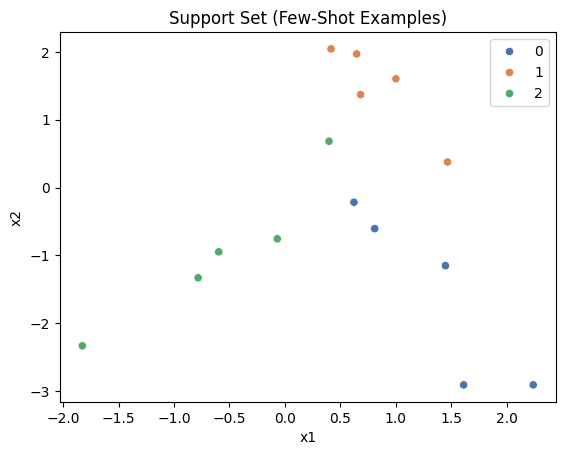

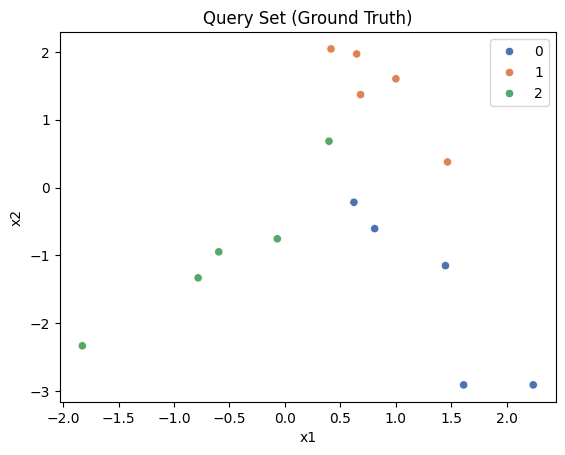

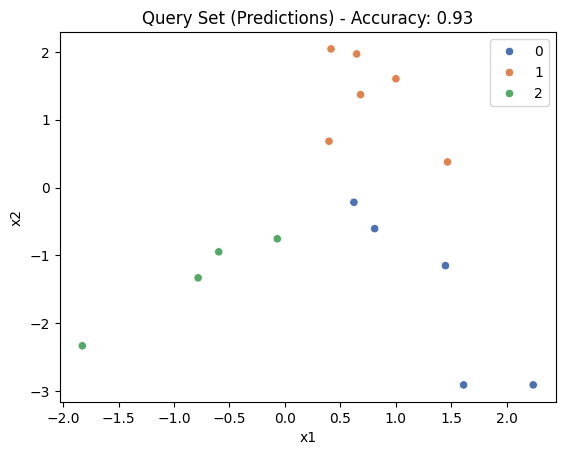

In [2]:
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

def generate_few_shot_data(n_classes=3, n_samples_per_class=5, n_features=2):
    X, y = make_classification(n_samples=n_classes * n_samples_per_class,
                               n_features=n_features, n_informative=2, n_redundant=0,
                               n_classes=n_classes, n_clusters_per_class=1, random_state=42)
    return X, y

support_X, support_y = generate_few_shot_data()
query_X, query_y = generate_few_shot_data()

clf = LogisticRegression()
clf.fit(support_X, support_y)
preds = clf.predict(query_X)
accuracy = accuracy_score(query_y, preds)

def plot_data(X, y, title):
    df = pd.DataFrame(X, columns=["x1", "x2"])
    df["label"] = y
    sns.scatterplot(data=df, x="x1", y="x2", hue="label", palette="deep")
    plt.title(title)
    plt.legend()
    plt.show()

plot_data(support_X, support_y, "Support Set (Few-Shot Examples)")
plot_data(query_X, query_y, "Query Set (Ground Truth)")
plot_data(query_X, preds, f"Query Set (Predictions) - Accuracy: {accuracy:.2f}")


## 2. Model-Agnostic Meta-Learning (MAML) on Sine Wave Regression

This example simulates the classic MAML setup, where the model must adapt to various sine wave functions
(with different amplitudes and phases) using only a few training samples per task.


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

def generate_sine_task(K=10):
    A = np.random.uniform(0.1, 5.0)
    phase = np.random.uniform(0, np.pi)
    x = np.random.uniform(-5, 5, size=(K, 1))
    y = A * np.sin(x + phase)
    return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 40),
            nn.ReLU(),
            nn.Linear(40, 1)
        )

    def forward(self, x):
        return self.net(x)

def maml_train_step(model, meta_lr=0.001, inner_lr=0.01, inner_steps=1, tasks=5, K=10):
    meta_optimizer = torch.optim.Adam(model.parameters(), lr=meta_lr)
    loss_fn = nn.MSELoss()

    for step in range(500):
        meta_loss = 0.0
        for _ in range(tasks):
            x_train, y_train = generate_sine_task(K)
            x_val, y_val = generate_sine_task(K)

            fast_weights = list(model.parameters())
            for _ in range(inner_steps):
                preds = model(x_train)
                loss = loss_fn(preds, y_train)
                grads = torch.autograd.grad(loss, model.parameters(), create_graph=True)
                fast_weights = [w - inner_lr * g for w, g in zip(fast_weights, grads)]

            pred_val = model(x_val)
            meta_loss += loss_fn(pred_val, y_val)

        meta_loss /= tasks
        meta_optimizer.zero_grad()
        meta_loss.backward()
        meta_optimizer.step()

        if step % 100 == 0:
            print(f"Step {step}: Meta Loss = {meta_loss.item():.4f}")

model = MLP()
maml_train_step(model)


Step 0: Meta Loss = 5.4431
Step 100: Meta Loss = 1.3557
Step 200: Meta Loss = 3.9095
Step 300: Meta Loss = 4.9449
Step 400: Meta Loss = 3.9325


## 3. Hebbian Learning Summary

Hebbian learning is a biologically inspired rule: **"Cells that fire together wire together"**.

Instead of using backpropagation, it updates synaptic weights based on correlations in neural activity.
This makes Hebbian models more interpretable and efficient for certain applications, though less precise than MAML.

 The NeurIPS 2020 paper on **Hebbian Meta-Learning** combines local learning rules with task adaptation,
showing promise in low-resource and online learning settings.
